In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import multimodal_vae
import torch_mvae_util as U
import util.RAVDESS_dataset_util as Rd
from train_mvae import build_model, train
from config_args import ConfigModelArgs, ConfigTrainArgs

In [3]:
cfg_model = ConfigModelArgs()
cfg_train = ConfigTrainArgs()
labels = list(Rd.emocat.values())
torch.manual_seed(100)

data_dir = '/home/studenti/ballerini/Multimodal_RSA/src/util/au-emo_2.csv'

In [4]:
#model_args, train_args = U.load_args(cfg_model, cfg_train)
model_args =  {'cat_dim': 8, 'au_dim': 17, 'latent_space_dim': 16, 'hidden_dim': 512, 'num_filters': None, 'modes': {'au': True, 'face': None, 'emotion': True}, 'au_weight': 394.28623761634674, 'emotion_weight': 0.0010840373351558375, 'expert_type': 'poe', 'use_cuda': True}
train_args =  {'learning_rate': 0.001, 'alpha': 0.1, 'beta': 1e-07, 'rec_weight': 10, 'optim_betas': [0.95, 0.98], 'num_epochs': 50, 'batch_size': 256}

trainset_loader, valset_loader, testset_loader = U.load_data(data_dir=data_dir, batch_size=train_args['batch_size'])


In [5]:
load_model = False

if load_model:    
    PATH = "../trained_models/au-emo-poe-52-93.save"
    #PATH = "../trained_models/au-emo-poe-63-48.save"
    #PATH = "../trained_models/best-train-poe.save"
    loaded_data = torch.load(PATH)
    
    model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
    print('model_args = ' , loaded_data['model_args'])
    print('train_args = ' , loaded_data['train_args'])
    model.load_state_dict(loaded_data['model_state'])
    eval_acc = None
else:
    model: torch.nn.Module = build_model(**model_args).double()
    training_losses, eval_acc = train(
        mvae_model=model,
        dataset_loader=trainset_loader,
        valset_loader=valset_loader,
        learning_rate=train_args['learning_rate'],
        optim_betas=train_args['optim_betas'],
        num_epochs=train_args['num_epochs'],
        alpha=train_args['alpha'],
        beta=train_args['beta'],
        rec_weight=train_args['rec_weight'],
        seed=100,
        checkpoint_every=None,
        use_cuda=True,
    )

100%|█████████████████████████████████████████████████████████████████████| 50/50 [03:32<00:00,  4.25s/it]


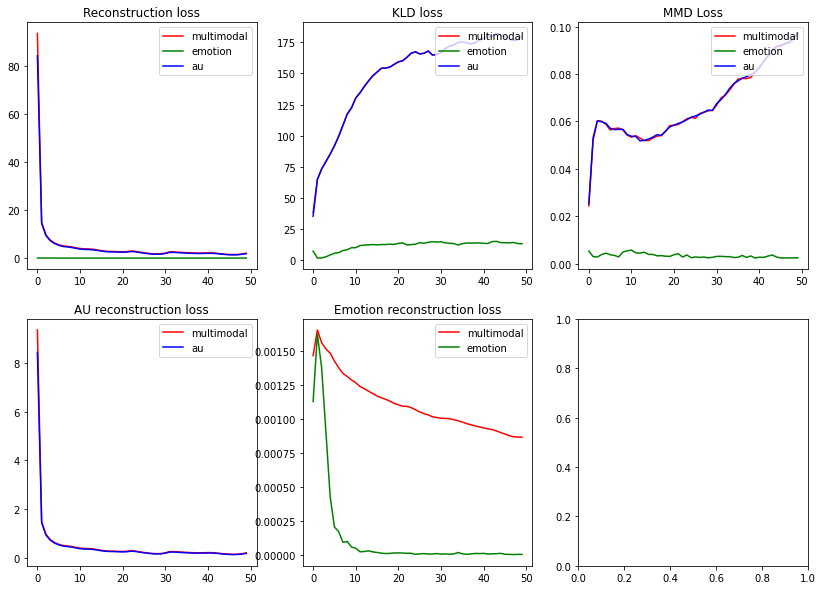

In [6]:
if not load_model: U.print_losses(training_losses)

In [7]:
if eval_acc is not None:
    idx = np.argmax(eval_acc)
    print ('Best model Accuracy: ', eval_acc[idx])
    print ('Best model Epoch: ', idx)
    '''
    PATH = "../trained_models/best_checkpoint.save"
    loaded_data = torch.load(PATH)
    model: torch.nn.Module = build_model(**model_args).double()
    model.load_state_dict(loaded_data['model_state'])
    model.eval()
    '''

Best model Accuracy:  0.6100946372239747
Best model Epoch:  45


In [8]:
with torch.no_grad():
    y_true, y_pred = U.au_classiffication_accuracy(model, trainset_loader)
    print('Trainset Accuracy: ', accuracy_score(y_true, y_pred))

Trainset Accuracy:  0.7001262626262627


Testset Accuracy:  0.6097930338213023


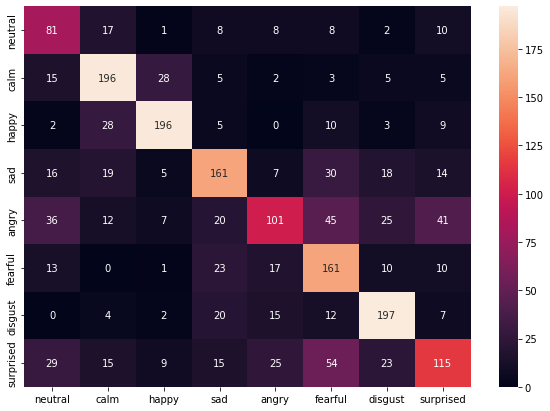

In [9]:
with torch.no_grad():
    y_true, y_pred = U.au_classiffication_accuracy(model, testset_loader)
    cr = classification_report(y_true, y_pred, target_names=labels)
    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

    plt.figure(figsize = (10,7))
    sn.heatmap(cm, annot=True, fmt="d")
    print('Testset Accuracy: ', accuracy_score(y_true, y_pred))

100%|████████████████████████████████████████████████████████████████| 2048/2048 [00:06<00:00, 327.40it/s]


0.8050537109375


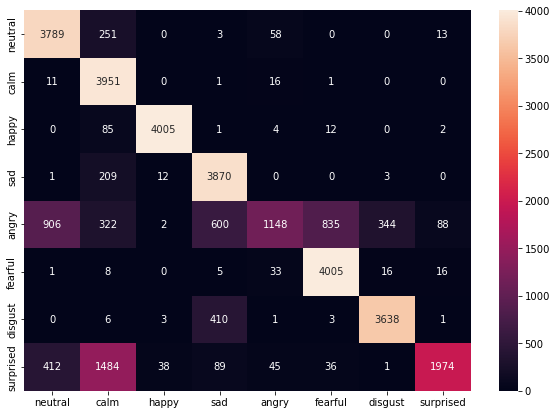

In [10]:
with torch.no_grad():
    y_true, y_pred = U.au_recon_and_classiffication_accuracy(model, num_samples=2048)
    cr = classification_report(y_true, y_pred, target_names=labels)
    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])
    plt.figure(figsize = (10,7))
    sn.heatmap(cm, annot=True, fmt="d")
    print(accuracy_score(y_true, y_pred))

In [11]:
save_model = False

if save_model:
    PATH = "../trained_models/au-emo-poe-56-83.save"
    torch.save({'model_args' : model_args,
                'train_args': train_args,
                'model_state' : model.state_dict()
               }, PATH)

In [12]:
Rd.emocat

{0: 'neutral',
 1: 'calm',
 2: 'happy',
 3: 'sad',
 4: 'angry',
 5: 'fearful',
 6: 'disgust',
 7: 'surprised'}

In [13]:
def generate_au(model, emo_idx, mul):
    emo = torch.tensor([emo_idx]).cuda()

    r_au, _, _, _, _ = model(au=None, emotions=emo)
    r_au *= (5 * mul)
    r_au.cpu()
    #r_au = torch.clamp(r_au, min=0, max=5)
    r_au = r_au.round()
    
    return Rd.emocat[emo_idx], r_au.tolist()[0]

In [14]:
for i in range(8):
    emo, au = generate_au(model, i, 2)
    print(emo)
    print(au)

neutral
[0.0, 2.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 2.0, 2.0, 1.0]
calm
[1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0]
happy
[3.0, 2.0, 0.0, 1.0, 1.0, 3.0, 0.0, 1.0, 3.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0]
sad
[2.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 3.0, 2.0, 2.0]
angry
[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]
fearful
[1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0]
disgust
[2.0, 0.0, 1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 2.0, 0.0, 1.0]
surprised
[1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 3.0, 1.0, 1.0, 0.0]
